<a href="https://colab.research.google.com/github/utkarshminhas/violence-detection-fyp/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set dataset paths

In [230]:
raw_rwf_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/Mini-RWF-2000'
processed_rwf_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/Processed'

# Export to frames

In [231]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import numpy as np

In [249]:
def generate_base_folders():
    if not os.path.exists(processed_rwf_dir):
        os.makedirs(processed_rwf_dir)

    categories = os.listdir(raw_rwf_dir)
    
    for category in categories:
        cur_op_dir = os.path.join(processed_rwf_dir, category)
        if not os.path.exists(cur_op_dir):
            os.makedirs(cur_op_dir)

def convert_to_frames():
    categories = os.listdir(raw_rwf_dir)

    for category in tqdm(categories):
        videos = os.listdir(os.path.join(raw_rwf_dir, category))

        for video in tqdm(videos, position=0, leave=True):
            generate_frames(category, video)


fgbg = cv2.createBackgroundSubtractorMOG2(
        varThreshold=15,
    detectShadows=True
)


def get_mask(frame):
    mog_mask = fgbg.apply(frame)
    median_blur_mask = cv2.medianBlur(mog_mask, 5)
    bilateral_filter_mask = cv2.bilateralFilter(median_blur_mask, 9, 75, 75)
    gaussian_blur_mask = cv2.GaussianBlur(bilateral_filter_mask, (13, 13), 5)

    return gaussian_blur_mask


def generate_frames(category, video):
    base_video_name, _ = os.path.splitext(video)
    video_ip_path = os.path.join(raw_rwf_dir, category, video)
    video_op_dir_path = os.path.join(processed_rwf_dir, category, base_video_name)

    if not os.path.exists(video_op_dir_path):
        os.makedirs(video_op_dir_path)

    cap = cv2.VideoCapture(video_ip_path)
    framerate = int(cap.get(5))

    capture_frequency = 5

    while True:
        frame_number = int(cap.get(1))
        success, frame = cap.read()

        if not success or frame is None:
            break

        masked_frame = get_mask(frame)

        if frame_number % capture_frequency == 1:
            exporting_frame_number = int(frame_number / capture_frequency)
            frame_path = os.path.join(video_op_dir_path, "frame_{0:0=3d}.jpg".format(exporting_frame_number))
            cv2.imwrite(frame_path, masked_frame)

        k = cv2.waitKey(30)

        if k == 27 or k == ord('q'):
            break

    cap.release()


In [ ]:
generate_base_folders()

with tf.device('/device:GPU:0'):
    convert_to_frames()

# Preprocessing

In [ ]:
# lalalal

# Model

## Some global variables

In [251]:
image_size = (128, 128)

label_to_int = {
    'Fight': 1,
    'NonFight': 0
}

batch_size = 2

## Training and validation generator

In [252]:
def preprocess(img):
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0

    temp = img
    img = []
    for r in range(len(temp)):
        cur_row = []
        for c in range(len(temp[r])):
            cur_row.append([temp[r][c]])
        img.append(cur_row)
    img = np.array(img)

    return img


def get_data(batch_size):
    data = []
    batch = []

    categories = os.listdir(processed_rwf_dir)

    for category in categories:
        videos = os.listdir(os.path.join(processed_rwf_dir, category))

        for video in videos:
            video_folder_path = os.path.join(processed_rwf_dir, category, video)
            batch.append([video_folder_path, label_to_int.get(category)])

            # If batch size is not a multiple of total number of videos, it will not return it since the if condition will never be satisfied
            if len(batch) == batch_size:
                data.append(batch)
                batch = []

    return data


def data_generator(data):
    for batch in data:
        x_set = []
        y_set = []

        for video, category in batch:
            current_video = []

            frames = os.listdir(video)
            for frame in frames:
                frame_path = os.path.join(video, frame)
                img = cv2.imread(frame_path)
                img = preprocess(img)

                current_video.append(img)

            x_set.append(current_video)
            y_set.append([category])

        x_set = np.array(x_set)
        y_set = np.array(y_set)

        yield (x_set, y_set)

data = get_data(batch_size)

In [254]:
gennifer = data_generator(data)

# for X, y in gennifer:
#     print(X.shape, y.shape)

# Model

## Imports

In [124]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 8.5MB/s 


In [255]:
from tensorflow.keras import layers
import numpy as np
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, \
Flatten, LSTM, Dropout, BatchNormalization
from keras import models
import itertools

import keras
from keras import optimizers
import tensorflow_addons as tfa

## Architecture

In [256]:
input_shape = (30, image_size[0], image_size[1], 1)

print(input_shape)

(30, 128, 128, 1)


In [257]:
model = models.Sequential(
    [
        TimeDistributed(
            Conv2D(64, (3, 3), activation=tf.nn.relu), 
            input_shape=input_shape
        ),
        # TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))),
        # TimeDistributed(Conv2D(128, (4, 4), activation=tf.nn.relu)),
        # TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
        # TimeDistributed(Conv2D(256, (4, 4), activation=tf.nn.relu)),
        # TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
        TimeDistributed(Flatten()),
        Dropout(0.5),
        # LSTM(256, return_sequences=False, dropout=0.5, input_shape=input_shape),
        Dense(1, activation=tf.nn.sigmoid)
    ]
)

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_37 (TimeDis (None, 30, 126, 126, 64)  640       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 1016064)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 1016064)       0         
_________________________________________________________________
dense_8 (Dense)              (None, 30, 1)             1016065   
Total params: 1,016,705
Trainable params: 1,016,705
Non-trainable params: 0
_________________________________________________________________


In [258]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()
model_path = 'cnn_lstm_model.h5'

callbacks_list = [
    # tqdm_callback,
    # keras.callbacks.EarlyStopping(monitor=['acc'], patience=3),
    # keras.callbacks.ModelCheckpoint(
    #     filepath=model_path,
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss",
    #     factor=0.1,
    #     patience=3
    # )
]

optimizer=optimizers.RMSprop(lr=0.06)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [259]:
gennifer = data_generator(data)
gennifer = itertools.cycle(gennifer)

with tf.device('/device:GPU:0'):
    history = model.fit(
        gennifer,
        steps_per_epoch=int(12/batch_size),
        # validation_data=ds_val,
        epochs=3,
        callbacks=callbacks_list,
        batch_size=batch_size
    )

Epoch 1/3
6/6 [==============================] - 12s 2s/step - loss: 0.2583 - acc: 0.8505
Epoch 2/3
6/6 [==============================] - 15s 2s/step - loss: 15.4249 - acc: 0.0000e+00
Epoch 3/3
6/6 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - acc: 1.0000


[0.9333333373069763, 0.0, 1.0] [0.11518057435750961, 15.424948692321777, 0.0]


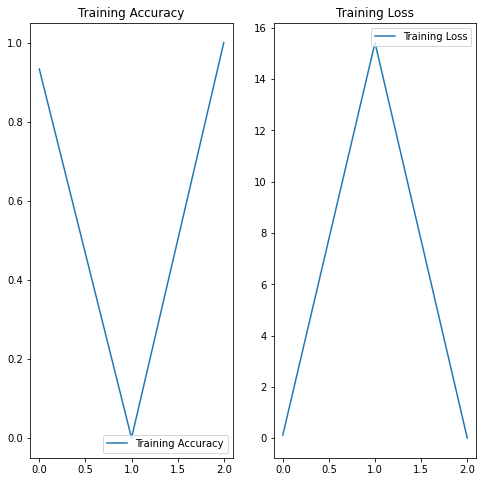

In [260]:
acc = history.history['acc']
loss = history.history['loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()